In [1]:
# !pip install tqdm
# !pip install catboost
# !pip install xgboost
# !pip install eli5
# !pip install -U colorama==0.4.4
# !pip install bayesian_optimization==1.4.0

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import missingno as msno
import seaborn as sns
import scipy.stats as st
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import xgboost as xg
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from eli5.sklearn import PermutationImportance
from eli5 import show_weights
from sklearn.tree import DecisionTreeRegressor
from bayes_opt import BayesianOptimization
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold, cross_val_score

# Исследование и анализ датасета.

In [2]:
#Загрузим данные из файла.
df = pd.read_excel('/home/rik/Рабочий стол/МИФИ/учеба/мо/curse/data.xlsx', index_col=0)
df.head()

IC50, mM    CC50, mM         SI  MaxAbsEStateIndex  MaxEStateIndex  \
0    6.239374  175.482382  28.125000           5.094096        5.094096   
1    0.771831    5.402819   7.000000           3.961417        3.961417   
2  223.808778  161.142320   0.720000           2.627117        2.627117   
3    1.705624  107.855654  63.235294           5.097360        5.097360   
4  107.131532  139.270991   1.300000           5.150510        5.150510   

   MinAbsEStateIndex  MinEStateIndex       qed        SPS    MolWt  ...  \
0           0.387225        0.387225  0.417362  42.928571  384.652  ...   
1           0.533868        0.533868  0.462473  45.214286  388.684  ...   
2           0.543231        0.543231  0.260923  42.187500  446.808  ...   
3           0.390603        0.390603  0.377846  41.862069  398.679  ...   
4           0.270476        0.270476  0.429038  36.514286  466.713  ...   

   fr_sulfide  fr_sulfonamd  fr_sulfone  fr_term_acetylene  fr_tetrazole  \
0           0             0           0                  0             0   
1           0             0           0                  0             0   
2           0             0           0                  0             0   
3           0             0           0                  0             0   
4           0             0           0                  0             0   

   fr_thiazole  fr_thiocyan  fr_thiophene  fr_unbrch_alkane  fr_urea  
0            0            0             0                 3        0  
1            0            0             0                 3        0  
2            0            0             0                 3        0  
3            0            0             0                 4        0  
4            0            0             0                 0        0  

[5 rows x 213 columns]

In [3]:
print("df.shape = {} rows, {} cols".format(*df.shape))

df.shape = 1001 rows, 213 cols


**Информация о нашем датасете**

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1001 entries, 0 to 1000
Columns: 213 entries, IC50, mM to fr_urea
dtypes: float64(107), int64(106)
memory usage: 1.6 MB


Мы выдим, что в нашем датасете 107 признаков имеют тип данных float64, а 106 int64.

In [5]:
df.describe()

IC50, mM     CC50, mM            SI  MaxAbsEStateIndex  \
count  1001.000000  1001.000000   1001.000000        1001.000000   
mean    222.805156   589.110728     72.508823          10.831637   
std     402.169734   642.867508    684.482739           3.307505   
min       0.003517     0.700808      0.011489           2.321942   
25%      12.515396    99.999036      1.433333           9.252350   
50%      46.585183   411.039342      3.846154          12.179236   
75%     224.975928   894.089176     16.566667          13.167843   
max    4128.529377  4538.976189  15620.600000          15.933463   

       MaxEStateIndex  MinAbsEStateIndex  MinEStateIndex          qed  \
count     1001.000000        1001.000000     1001.000000  1001.000000   
mean        10.831637           0.180681       -0.967237     0.580412   
std          3.307505           0.168710        1.588036     0.212230   
min          2.321942           0.000039       -6.992796     0.059567   
25%          9.252350           0.051073       -1.334487     0.442842   
50%         12.179236           0.124606       -0.419485     0.634981   
75%         13.167843           0.291020        0.061754     0.742483   
max         15.933463           1.374614        1.374614     0.947265   

               SPS        MolWt  ...   fr_sulfide  fr_sulfonamd   fr_sulfone  \
count  1001.000000  1001.000000  ...  1001.000000   1001.000000  1001.000000   
mean     29.487989   348.262234  ...     0.053946      0.011988     0.008991   
std      12.742749   126.946370  ...     0.259011      0.108886     0.094441   
min       9.416667   110.156000  ...     0.000000      0.000000     0.000000   
25%      18.486486   264.321000  ...     0.000000      0.000000     0.000000   
50%      29.290323   315.457000  ...     0.000000      0.000000     0.000000   
75%      38.750000   409.283000  ...     0.000000      0.000000     0.000000   
max      60.272727   904.777000  ...     2.000000      1.000000     1.000000   

       fr_term_acetylene  fr_tetrazole  fr_thiazole  fr_thiocyan  \
count        1001.000000   1001.000000  1001.000000       1001.0   
mean            0.000999      0.000999     0.051948          0.0   
std             0.031607      0.031607     0.222033          0.0   
min             0.000000      0.000000     0.000000          0.0   
25%             0.000000      0.000000     0.000000          0.0   
50%             0.000000      0.000000     0.000000          0.0   
75%             0.000000      0.000000     0.000000          0.0   
max             1.000000      1.000000     1.000000          0.0   

       fr_thiophene  fr_unbrch_alkane      fr_urea  
count   1001.000000       1001.000000  1001.000000  
mean       0.069930          0.204795     0.006993  
std        0.255157          1.215326     0.083373  
min        0.000000          0.000000     0.000000  
25%        0.000000          0.000000     0.000000  
50%        0.000000          0.000000     0.000000  
75%        0.000000          0.000000     0.000000  
max        1.000000         20.000000     1.000000  

[8 rows x 213 columns]

Одна из наших целевых переменных IC50, mM имеет большую разницу между средним и меданным значением, что может говорить о наличии выбросов. Также MaxAbsEStateIndex и MaxEStateIndex	имеют одинаковые значения, возможно они дублируют друг друга.

# Анализ числовых признаков¶

## Дескретные признаки

In [6]:
discrete_feature = [
    feature for feature in df.columns
    if len(df[feature].unique())<25
]

print(f"Discrete Variables Count: {len(discrete_feature)}")


Discrete Variables Count: 110


In [7]:
df[discrete_feature].head()

NumRadicalElectrons  PEOE_VSA13  PEOE_VSA5  SMR_VSA2  SMR_VSA8  \
0                    0         0.0        0.0       0.0         0   
1                    0         0.0        0.0       0.0         0   
2                    0         0.0        0.0       0.0         0   
3                    0         0.0        0.0       0.0         0   
4                    0         0.0        0.0       0.0         0   

   SlogP_VSA11  SlogP_VSA7  SlogP_VSA9  EState_VSA11  NHOHCount  ...  \
0          0.0         0.0           0           0.0          0  ...   
1          0.0         0.0           0           0.0          2  ...   
2          0.0         0.0           0           0.0          0  ...   
3          0.0         0.0           0           0.0          0  ...   
4          0.0         0.0           0           0.0          0  ...   

   fr_sulfide  fr_sulfonamd  fr_sulfone  fr_term_acetylene  fr_tetrazole  \
0           0             0           0                  0             0   
1           0             0           0                  0             0   
2           0             0           0                  0             0   
3           0             0           0                  0             0   
4           0             0           0                  0             0   

   fr_thiazole  fr_thiocyan  fr_thiophene  fr_unbrch_alkane  fr_urea  
0            0            0             0                 3        0  
1            0            0             0                 3        0  
2            0            0             0                 3        0  
3            0            0             0                 4        0  
4            0            0             0                 0        0  

[5 rows x 110 columns]

Некоторые признаки имеют нулевые значения. Проверим сколько признаков имеют не нулевые значения.

In [8]:
%%time
count_discrete_feature = {}
for i in tqdm(discrete_feature):
    cnt = 0
    for j in df[i]:
        if j != 0:
            cnt += 1
    count_discrete_feature[f'{i}'] = cnt
count_discrete_feature = pd.Series(count_discrete_feature).sort_values(ascending=False)

100%|███████████████████████████████████████| 110/110 [00:00<00:00, 4046.64it/s]

CPU times: user 32 ms, sys: 0 ns, total: 32 ms
Wall time: 70.7 ms


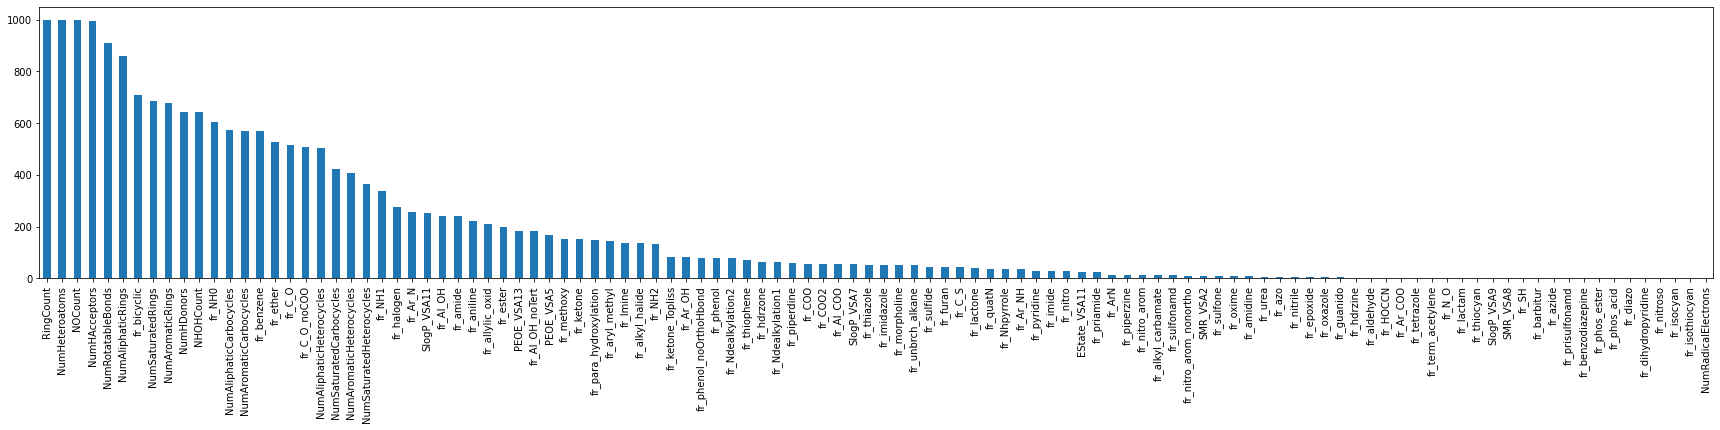

In [9]:
fig = plt.figure(figsize=(30,5))
count_discrete_feature.plot(kind='bar')
plt.show()

In [14]:
zero_feature = count_discrete_feature[count_discrete_feature == 0].count()
print(f'Количество нулевых признаков: {zero_feature}')

Количество нулевых признаков: 18


Визуально мы можем увидеть, что есть признаки которые имеют только нулевые значения, есть признаки которые имеют большое количество нулевых значений и есть признаки которые имеют мало нулевых значений.

Признаки которые имеют только нулевые значения для модели будут бесполезными, удалим их сразу. Остальные признаки нужно будет изучить более детально.

In [11]:
df = df.drop(columns=count_discrete_feature[count_discrete_feature == 0].index.to_list())

In [12]:
count_discrete_feature = count_discrete_feature[count_discrete_feature > 0]

Постараемся найти зависимость между дескретными признаками и целевыми переменными.

Посмотрим столбчатую диаграмму зависимостей признаков и целевой переменной IC50, mM

In [13]:
fig, axes = plt.subplots(31, 3, figsize=(60, 300))

for num, feature in enumerate(count_discrete_feature.index):
    data = df.copy()
    statistics = data.groupby([feature])["IC50, mM"].median()

    sns.barplot(
        x=statistics.index,
        y=statistics.values,
        palette="viridis",
        ax=axes[num%31, num//31]
    )

Признаки имеют категории которые имеют выраженную связь с целевой переменной

Посмотрим столбчатую диаграмму зависимостей признаков и целевой переменной CC50, mM

In [14]:
fig, axes = plt.subplots(31, 3, figsize=(60, 300))

for num, feature in enumerate(count_discrete_feature.index):
    data = df.copy()
    statistics = data.groupby([feature])["CC50, mM"].median()

    sns.barplot(
        x=statistics.index,
        y=statistics.values,
        palette="viridis",
        ax=axes[num%31, num//31]
    )

Большинство признаков распределены равномерно.

Посмотрим столбчатую диаграмму зависимостей признаков и целевой переменной SI

In [15]:
fig, axes = plt.subplots(31, 3, figsize=(60, 300))

for num, feature in enumerate(count_discrete_feature.index):
    data = df.copy()
    statistics = data.groupby([feature])["SI"].median()

    sns.barplot(
        x=statistics.index,
        y=statistics.values,
        palette="viridis",
        ax=axes[num%31, num//31]
    )
    


Признаки имеют категории которые имеют выраженную связь с целевой переменной


# Непрерывные признаки

In [16]:
continuous_feature = [
    feature for feature in df.columns
    if feature not in discrete_feature]

print(f"Continuous Feature Count {len(continuous_feature)}")

Continuous Feature Count 103


**Построение гистограмм числовых непрерывных признаков**

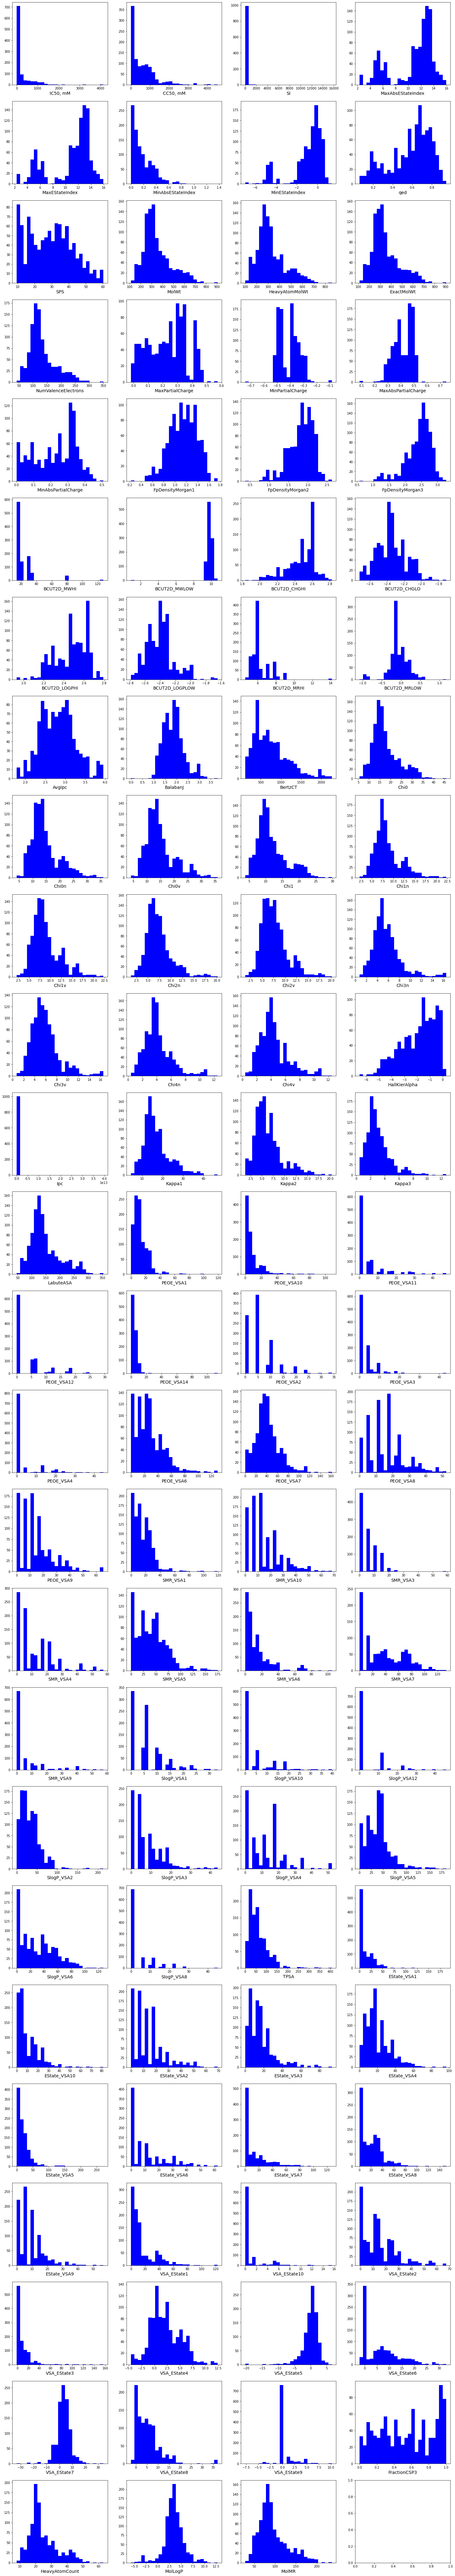

In [17]:
fig, axes = plt.subplots(26, 4, figsize=(25, 150))

for num, feature in enumerate(continuous_feature):
    data = df[feature].copy()

    axes[num//4, num%4].hist(data, bins=25, color="blue")
    axes[num//4, num%4].set_xlabel(feature, fontsize=14)

Большинство признаков имеют разное распределение, что говорит о хорошей разделяющей способности данных признаков, но есть признаки с похожим распределением, данные признаки нужно будет изучить более пристально.

## Анализ пропусков

<AxesSubplot:>

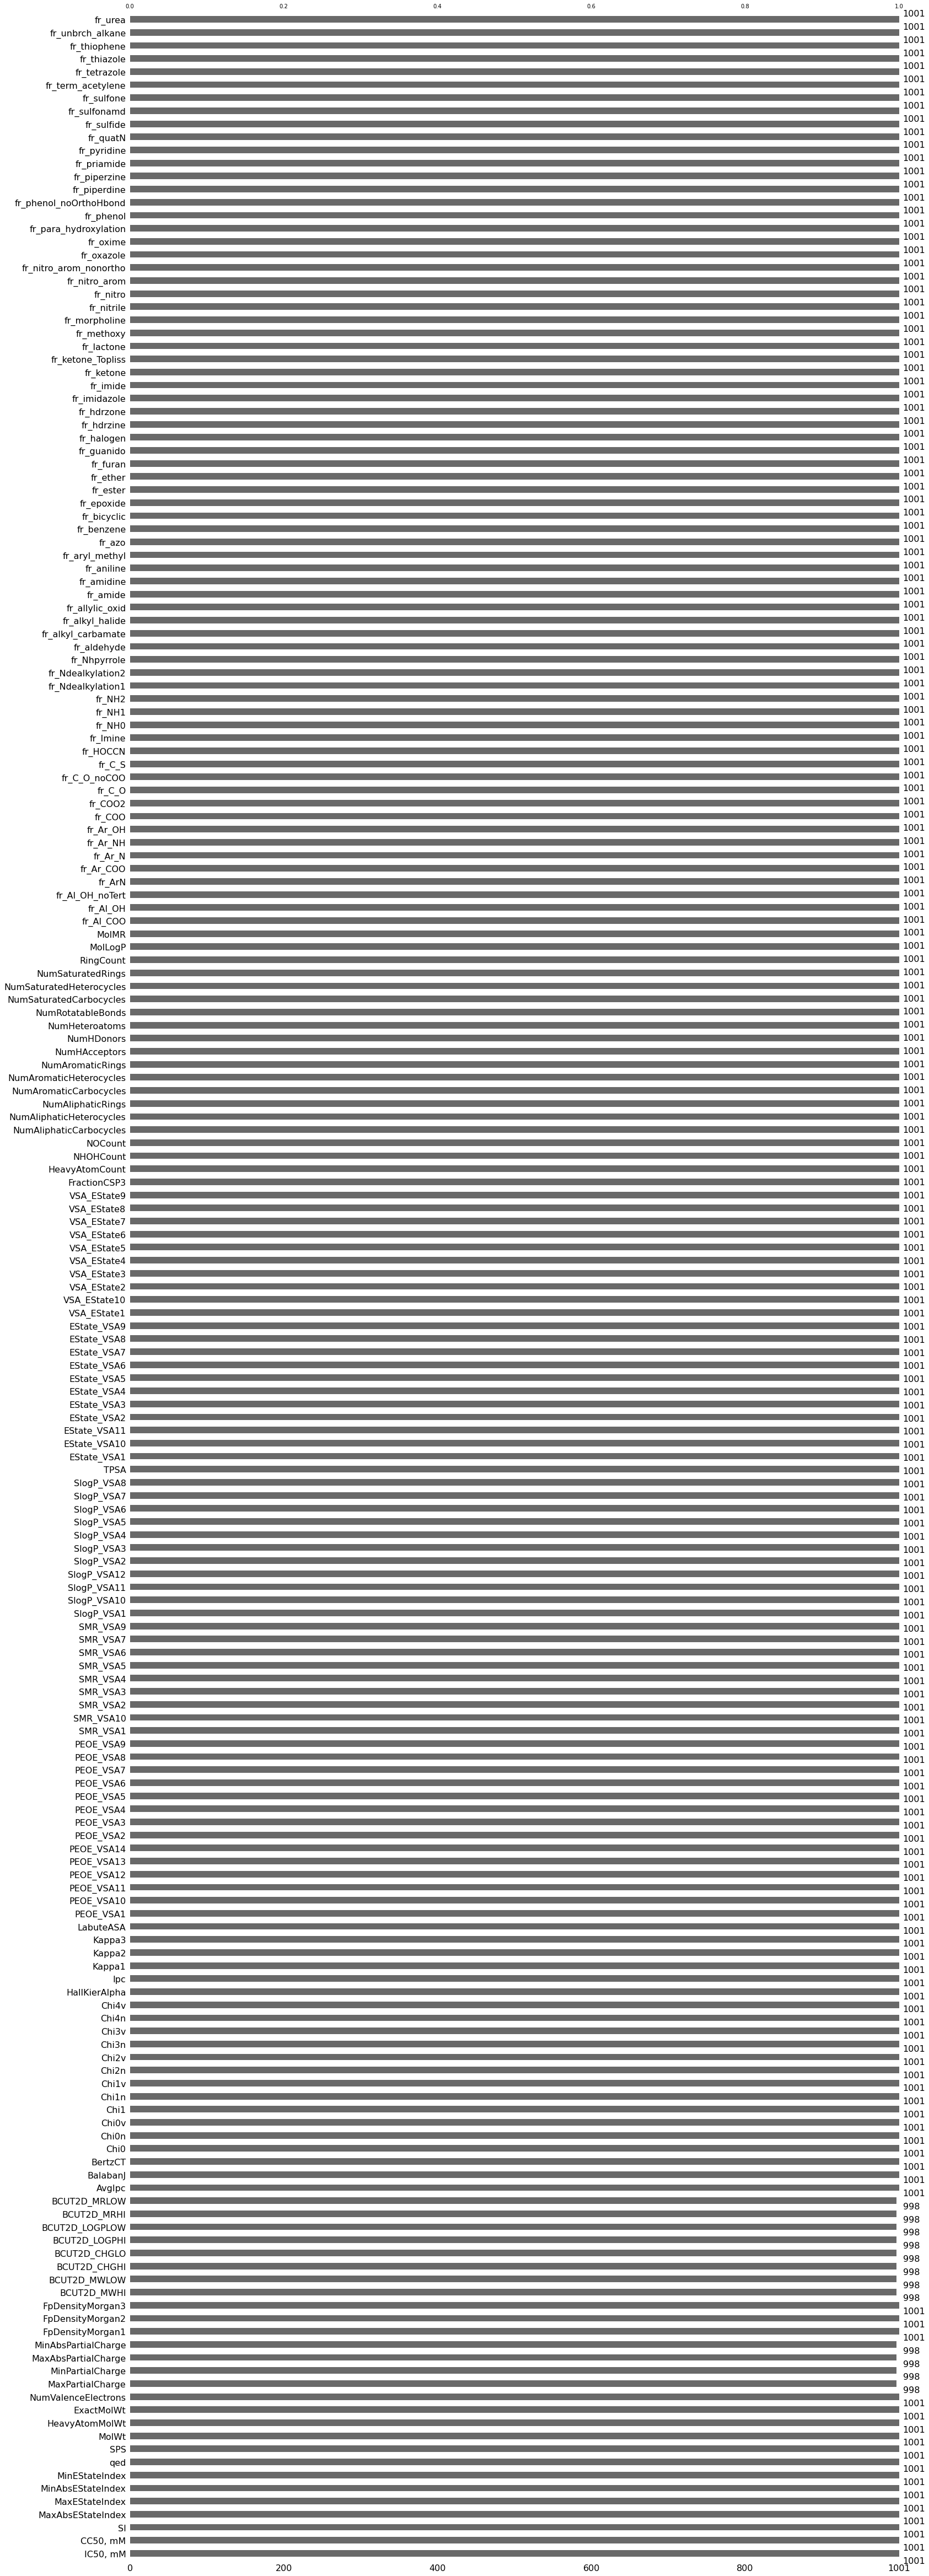

In [18]:
msno.bar(df)

12 признаков имеют 3 пропуска.

Удалим эти 3 строки.

In [19]:
df = df.dropna()

## Корреляция между числовыми признаками

In [20]:
correlation = df.corr()

<AxesSubplot:title={'center':'Correlation of Numeric Features'}>

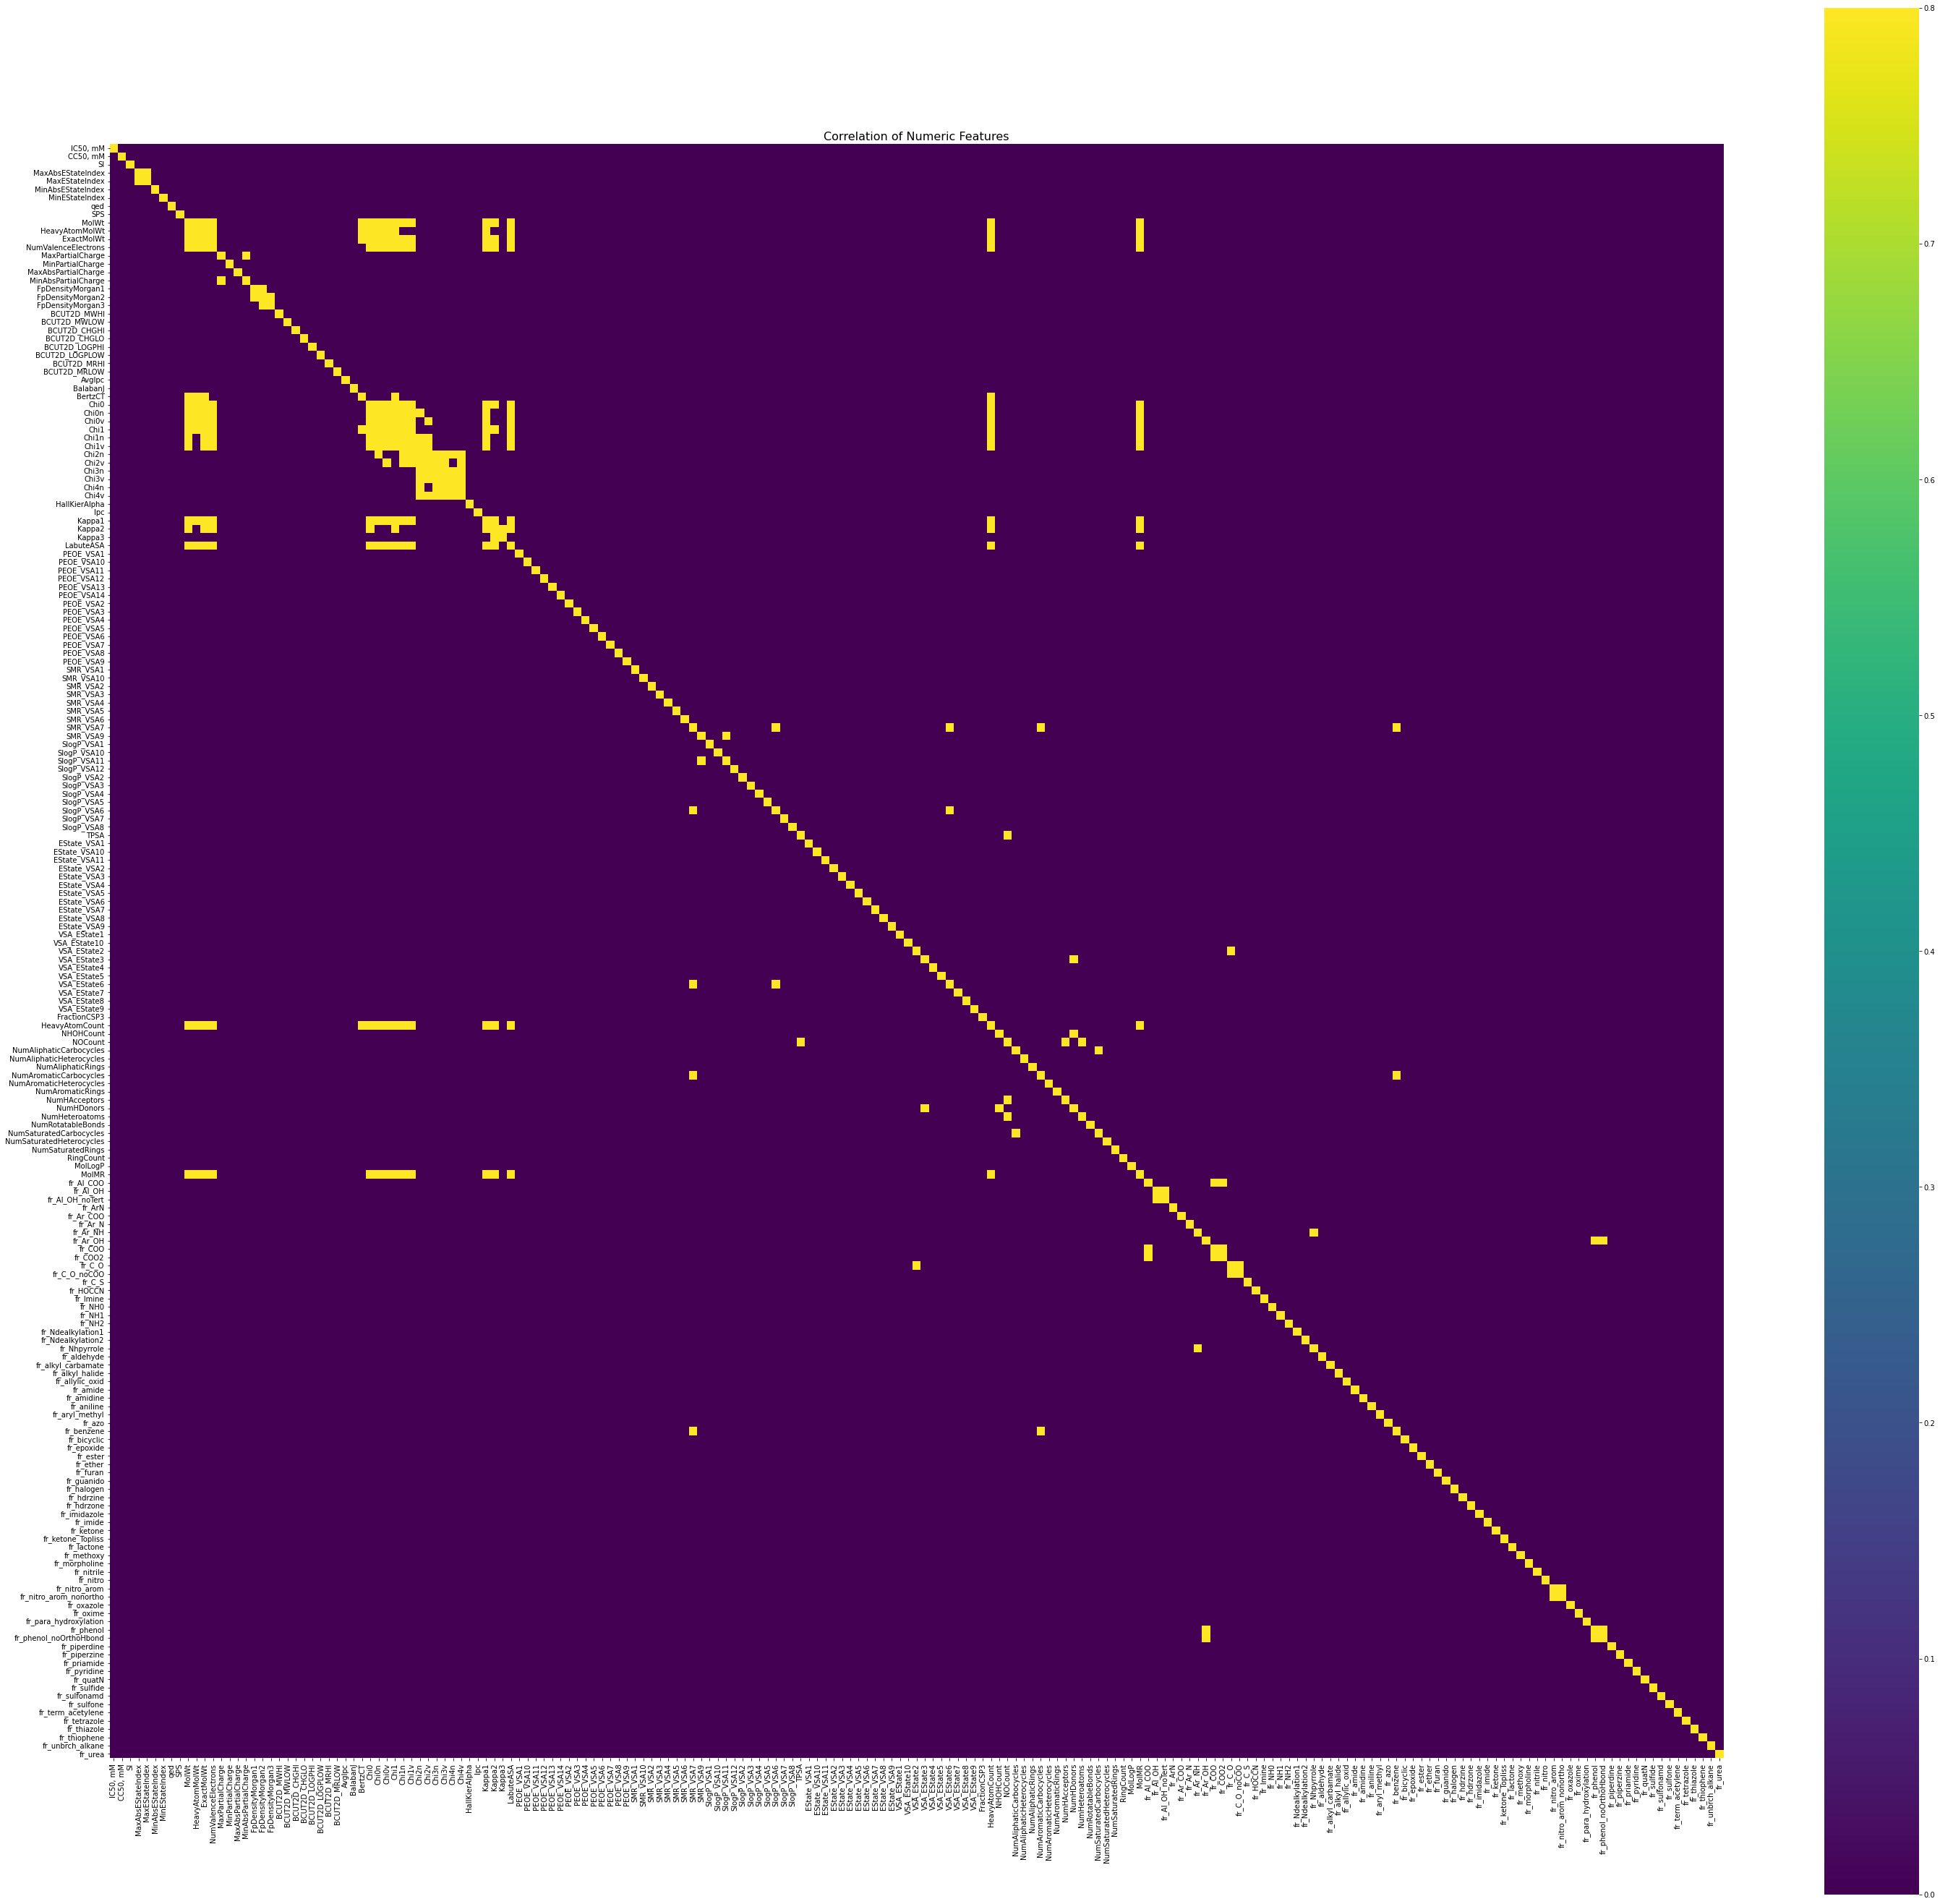

In [21]:
fig, axes = plt.subplots(figsize = (50,48))
plt.title("Correlation of Numeric Features", y=1, size=16)
sns.heatmap(correlation > 0.9, square=True, vmax=0.8, cmap="viridis")

Проанализировав корреляционную матрицу можно увидеть большое количество признаков с высокой корреляцией более 90% между ними: 
fr_phenol - fr_phenol_noOrthoHbond, fr_Al_OH - fr_phenol, fr_Al_OH - fr_phenol_noOrthoHbond,fr_nitro_arom - fr_nitro_arom_nonortho,fr_Al_OH_noTert - fr_Al_OH,NHOHCount - NumHDonors,VSA_EState3 - NumHDonors,fr_C_O - fr_C_O_noCOO,fr_C_O - VSA_EState2,fr_benzene - NumAromaticCarbocycles,NumAromaticCarbocycles - SMR_VSA7,fr_benzene - SMR_VSA7,SMR_VSA7 - VSA_EState6,SMR_VSA7 - SlogP_VSA6,
VSA_EState6 - SlogP_VSA6,fr_Nhpyrrole - fr_Ar_NH,fr_COO - fr_COO2,fr_COO - fr_Al_COO,fr_COO2 - fr_Al_COO,fr_Ar_NH - fr_Nhpyrrole,MolMR - HeavyAtomMolWt,MolMR - Kappa1,MolMR - MolWt, MolMR - ExactMolWt, MolMR - Chi0, MolMR - Chi1, MolMR - HeavyAtomCount,MolMR - NumValenceElectrons,MolMR - Chi1n,MolMR - Chi1v,MolMR - Chi0n,MolMR - LabuteASA,MolMR - Chi0v,MolMR - Kappa2,Kappa2 - Chi0n,Kappa2 - Chi0v,Kappa2 - Kappa1,Kappa2 - Kappa3,HeavyAtomCount - Chi0,HeavyAtomCount - Chi1,HeavyAtomCount -LabuteASA,HeavyAtomCount - NumValenceElectrons,
HeavyAtomCount - ExactMolWt, HeavyAtomCount - MolWt, HeavyAtomCount - HeavyAtomMolWt,HeavyAtomCount - Kappa1, HeavyAtomCount - Chi0v,HeavyAtomCount - Chi0n,HeavyAtomCount - Chi1n,HeavyAtomCount - Chi1v,HeavyAtomCount - Kappa2,Chi1 - BertzCT,Chi1 - Chi0,Chi1 - LabuteASA,Chi1 - NumValenceElectrons,Chi1 - ExactMolWt,Chi1 - MolWt, Chi1 - HeavyAtomMolWt,Chi1 - Kappa1,Chi1 - Chi0v,Chi1 - Chi0n,Chi1 - Chi1n,Chi1 - Chi1v,Chi1 - Kappa2,Chi0 - LabuteASA,Chi0 - NumValenceElectrons,Chi0 - ExactMolWt, Chi0 - MolWt, Chi0 - HeavyAtomMolWt,Chi0 - Kappa1,Chi0 - Chi0v,Chi0 - Chi0n,Chi0 - Chi1n,Chi0 - Chi1v,Chi0 - Kappa2,LabuteASA - NumValenceElectrons,LabuteASA - ExactMolWt, LabuteASA - MolWt,LabuteASA - HeavyAtomMolWt,LabuteASA - Kappa1,LabuteASA - Chi0v, LabuteASA - Chi0n, LabuteASA - Chi1n, LabuteASA - Chi1v, LabuteASA - Kappa2, NumValenceElectrons - ExactMolWt, NumValenceElectrons - MolWt, NumValenceElectrons - HeavyAtomMolWt, NumValenceElectrons - Kappa1, NumValenceElectrons - Chi0v, NumValenceElectrons - Chi0n,NumValenceElectrons - Chi1n, NumValenceElectrons - Chi1v,NumValenceElectrons - Kappa2,
ExactMolWt - MolWt,ExactMolWt - HeavyAtomMolWt,ExactMolWt - Kappa1,ExactMolWt - Chi0v,ExactMolWt - Chi0n, ExactMolWt - Chi1n, ExactMolWt - Chi1v,ExactMolWt - Kappa2,MolWt - HeavyAtomMolWt,MolWt - Kappa1,MolWt - Chi0v, MolWt - Chi0n,MolWt - Chi1n, MolWt - Chi1v,MolWt - Kappa2,HeavyAtomMolWt - Kappa1,HeavyAtomMolWt - Chi0v, HeavyAtomMolWt - Chi0n, HeavyAtomMolWt - Chi1n, Kappa1 - Chi0v, Kappa1 - Chi0n, Kappa1 - Chi1n, Kappa1 - Chi1v,
Chi0v - Chi0n,Chi0v - Chi1n,Chi0v - Chi1v,Chi0n - Chi1n,Chi0n - Chi1v,Chi1n - Chi1v,NumAliphaticCarbocycles - NumSaturatedCarbocycles,NumAliphaticCarbocycles - SMR_VSA4,Kappa1 - Chi0n,Chi0n - Chi0v,NOCount - NumHeteroatoms, 
NOCount - TPSA,NOCount - NumHAcceptors,SlogP_VSA11 - SMR_VSA9,Chi4v - Chi2n,Chi4v - Chi2v,Chi4v - Chi3n,Chi4v - Chi3v,Chi4v - Chi4n,Chi4n - Chi2n,Chi4n - Chi3n,Chi4n - Chi3v,Chi3v - Chi2n,Chi3v - Chi2v,Chi3v - Chi3n,Chi3n - Chi2n,Chi3n - Chi2v,Chi2v - Chi1v,Chi2v - Chi2n,Chi2v - Chi1n,Chi2n - Chi1v,BertzCT - HeavyAtomMolWt,BertzCT - Chi1,BertzCT - HeavyAtomCount,BertzCT - MolWt,BertzCT - ExactMolWt,FpDensityMorgan1 - FpDensityMorgan2,FpDensityMorgan2 - FpDensityMorgan3,MaxAbsPartialCharge - MaxEStateIndex,MaxEStateIndex - MaxAbsEStateIndex, MaxPartialCharge - MinAbsPartialCharge, Chi0n - Chi2n

Удалим признаки: 'BertzCT', 'Chi0', 'Chi0v', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n', 'Chi4v','ExactMolWt', 'FpDensityMorgan1', 'FpDensityMorgan3', 'HeavyAtomCount', 'HeavyAtomMolWt', 'Kappa1', 'Kappa2', 'Kappa3', 'LabuteASA', 'MaxAbsEStateIndex', 'MaxAbsPartialCharge', 'MolMR', 'MolWt', 'NHOHCount', 'NumAromaticCarbocycles', 'NumHAcceptors', 'NumHeteroatoms', 'NumSaturatedCarbocycles', 'NumValenceElectrons', 'SMR_VSA4', 'SMR_VSA9', 'SlogP_VSA6', 'TPSA', 'VSA_EState2', 'VSA_EState3', 'VSA_EState6', 'fr_Al_OH_noTert', 'fr_COO', 'fr_COO2', 'fr_C_O_noCOO', 'fr_Nhpyrrole', 'fr_benzene', 'fr_nitro_arom_nonortho', 'fr_phenol', 'fr_phenol_noOrthoHbond', 'MinAbsPartialCharge', 'Chi2n'. Оставим наиболее встречающиеся признаки: fr_nitro_arom, NumHDonors, fr_C_O, fr_Ar_NH, Chi0n,
fr_Al_COO, Chi0n, Chi2n, SMR_VSA7, NOCount, fr_Al_OH, MaxEStateIndex, FpDensityMorgan2, NumAliphaticCarbocycles,
SlogP_VSA11, MaxPartialCharge.  


In [22]:
feature_del = ['BertzCT', 'Chi0', 'Chi0v', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n', 'Chi4v',
 'ExactMolWt', 'FpDensityMorgan1', 'FpDensityMorgan3', 'HeavyAtomCount', 'HeavyAtomMolWt', 'Kappa1', 'Kappa2',
 'Kappa3', 'LabuteASA', 'MaxAbsEStateIndex', 'MaxAbsPartialCharge', 'MolMR', 'MolWt', 'NHOHCount', 'NumAromaticCarbocycles',
 'NumHAcceptors', 'NumHeteroatoms', 'NumSaturatedCarbocycles', 'NumValenceElectrons', 'SMR_VSA4', 'SMR_VSA9',
 'SlogP_VSA6', 'TPSA', 'VSA_EState2', 'VSA_EState3', 'VSA_EState6', 'fr_Al_OH_noTert', 'fr_COO', 'fr_COO2',
 'fr_C_O_noCOO', 'fr_Nhpyrrole', 'fr_benzene', 'fr_nitro_arom_nonortho', 'fr_phenol', 'fr_phenol_noOrthoHbond',
'MinAbsPartialCharge', 'Chi2n' 
]

In [23]:
df = df.drop(columns=feature_del)

<AxesSubplot:title={'center':'Correlation of Numeric Features'}>

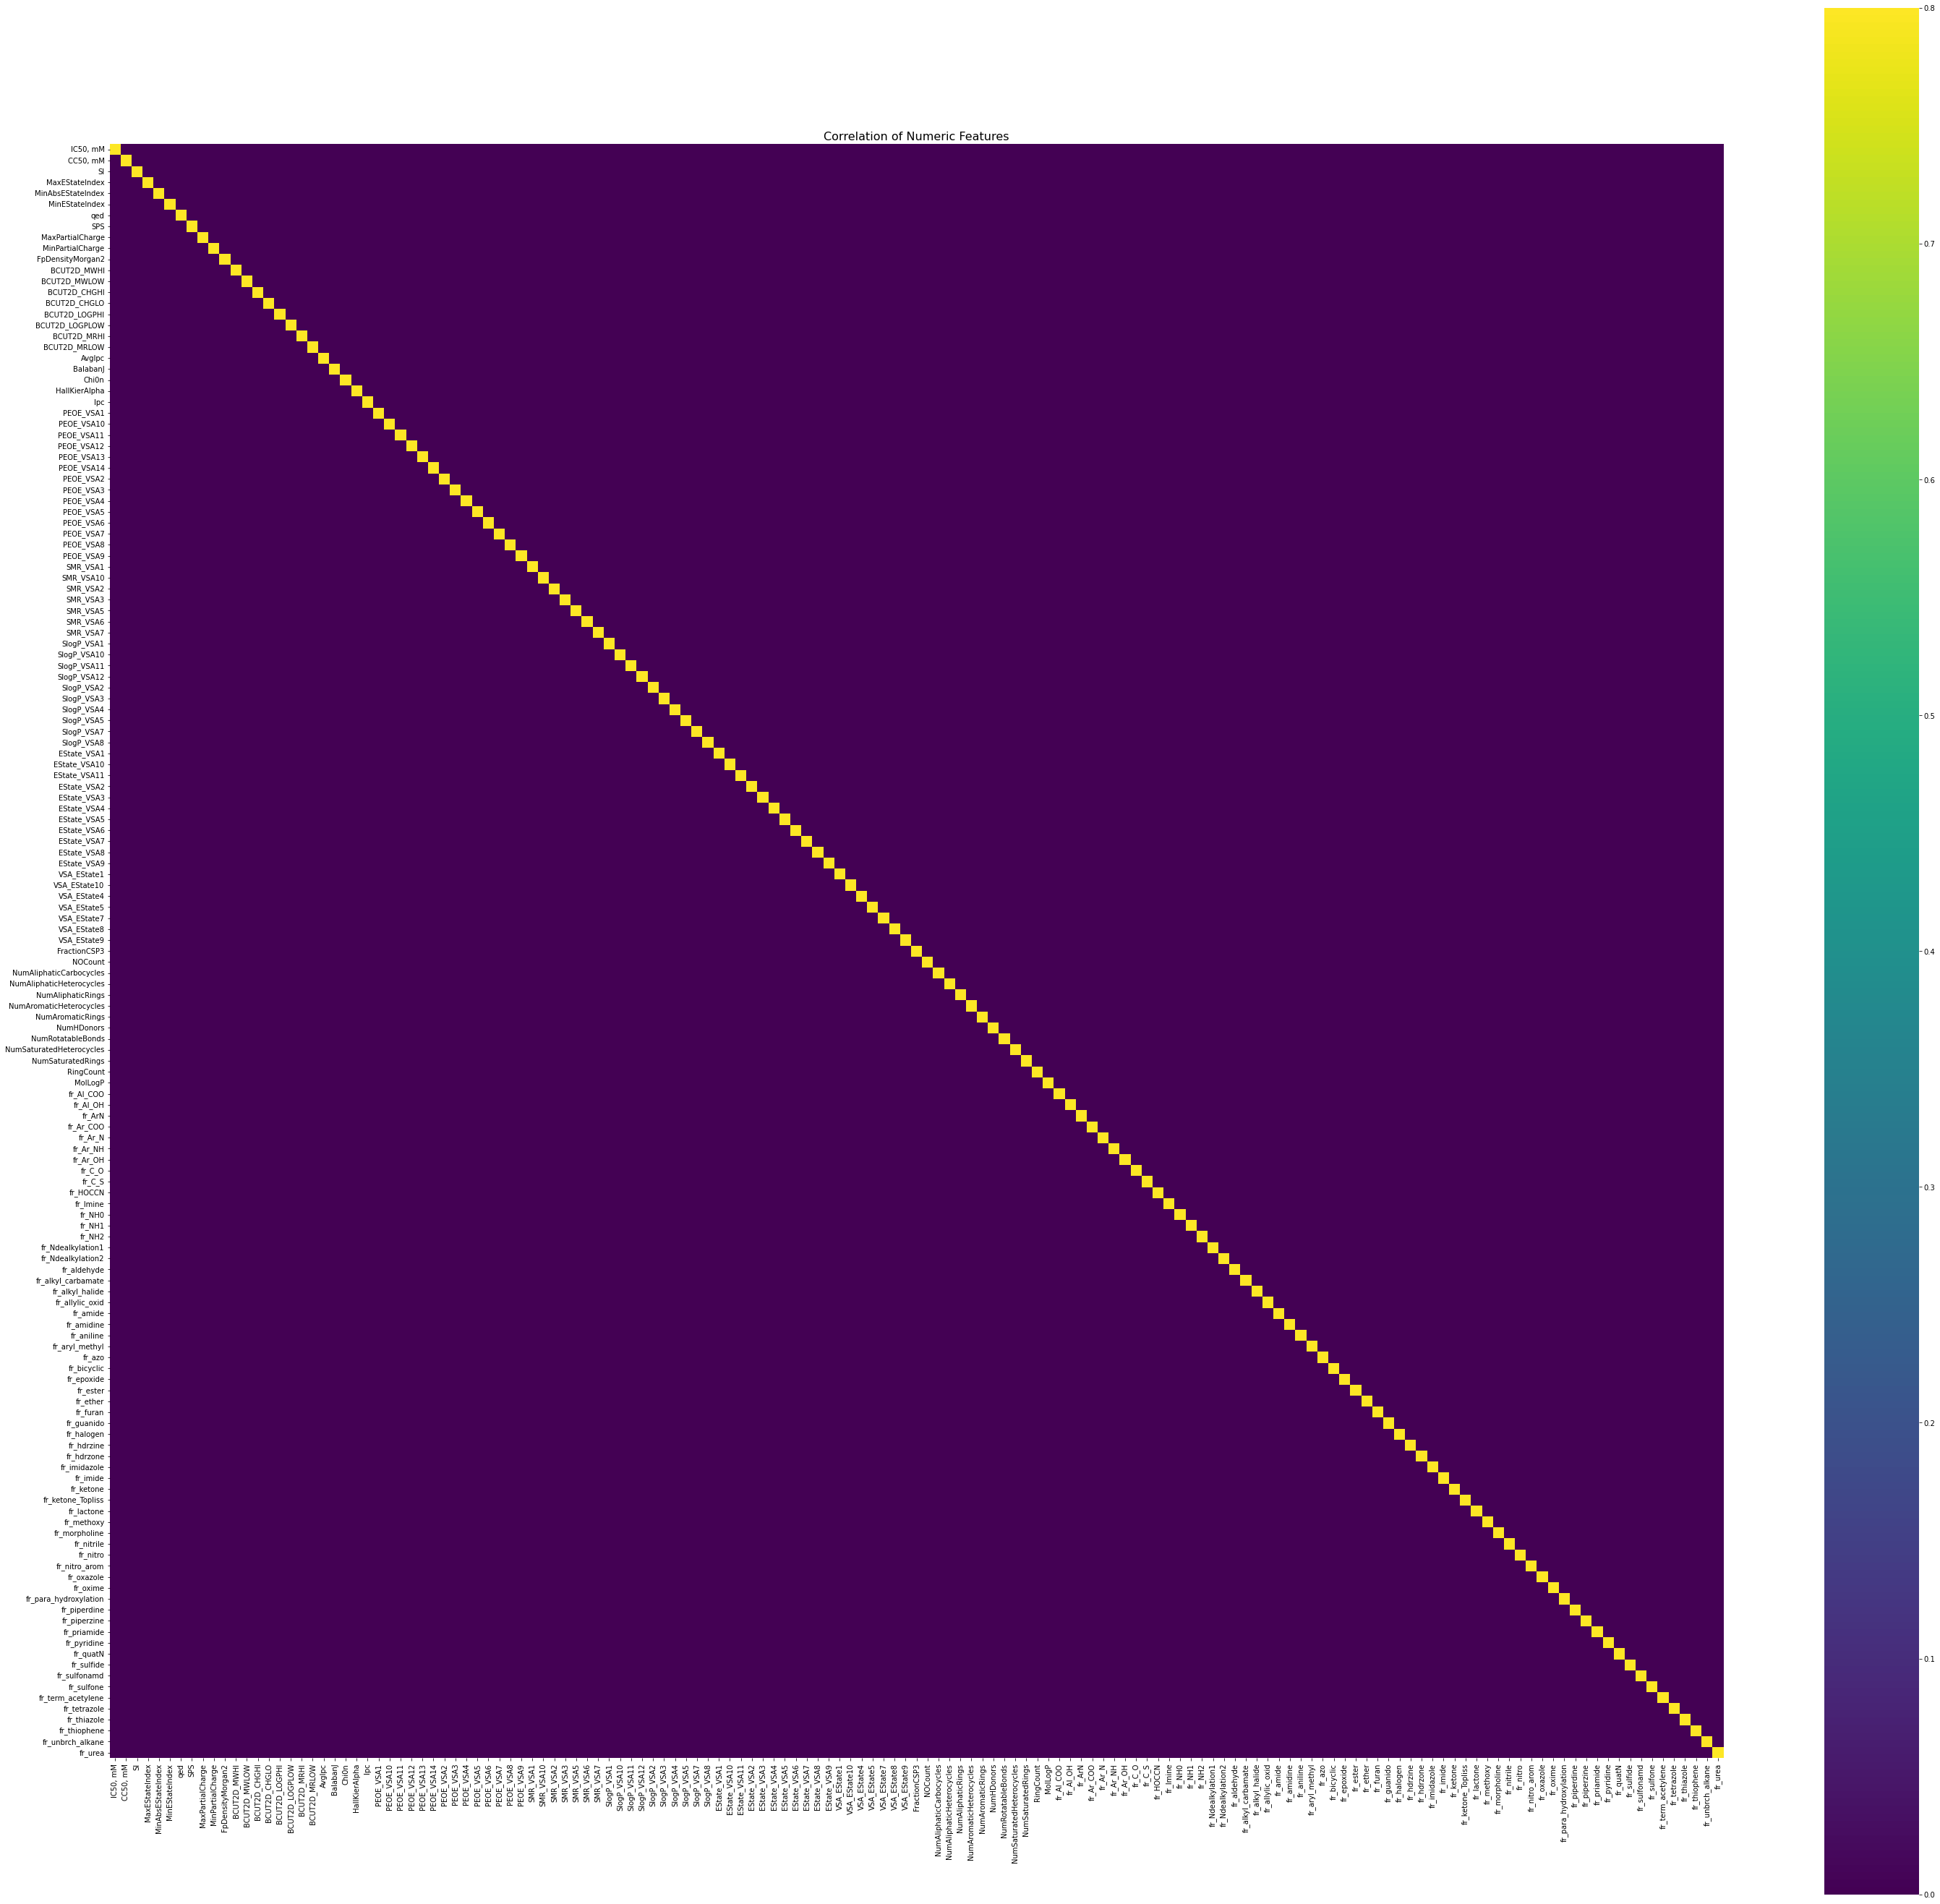

In [24]:
correlation_clear = df.corr()
fig, axes = plt.subplots(figsize = (50,48))
plt.title("Correlation of Numeric Features", y=1, size=16)
sns.heatmap(correlation_clear > 0.9, square=True, vmax=0.8, cmap="viridis")


Теперь у нас не осталость признаков с высоким коэффициентом корреляции.

**Корреляция с целевой переменной IC50, mM(TOP 10)**

<AxesSubplot:>

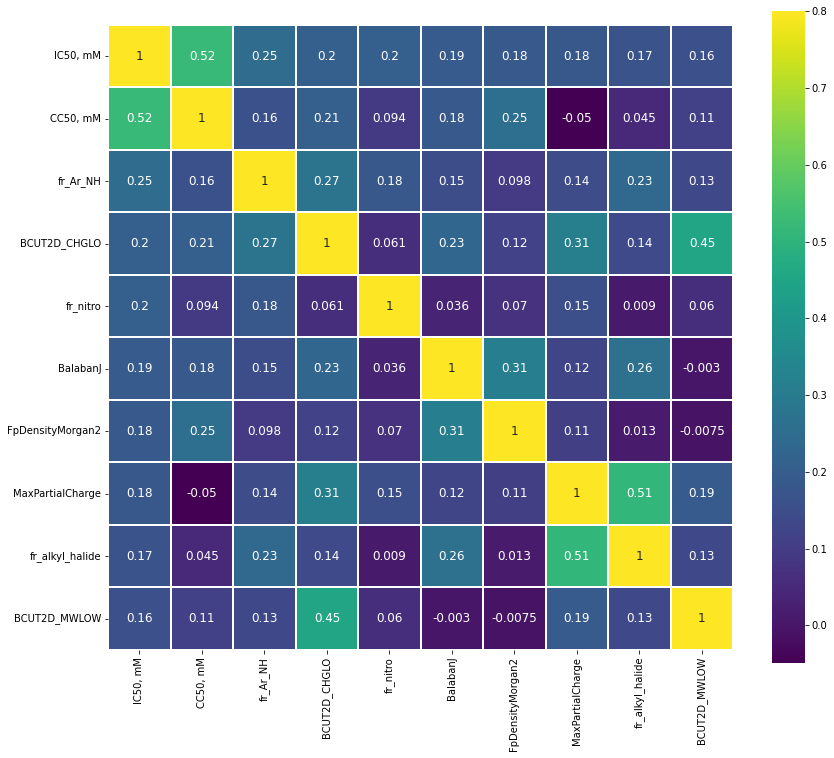

In [25]:
k = 10
cols = correlation_clear.nlargest(k,  'IC50, mM')[ 'IC50, mM'].index
cm = np.corrcoef(df[cols].values.T)
fig, axes = plt.subplots(figsize = (14, 12))

sns.heatmap(
    cm,
    vmax=.8,
    linewidths=0.01,
    cmap="viridis",
    square=True,
    annot=True,
    linecolor="white",
    xticklabels=cols.values,
    annot_kws = {"size": 12},
    yticklabels=cols.values
)

**Корреляция с целевой переменной CC50, mM(TOP 10)**

<AxesSubplot:>

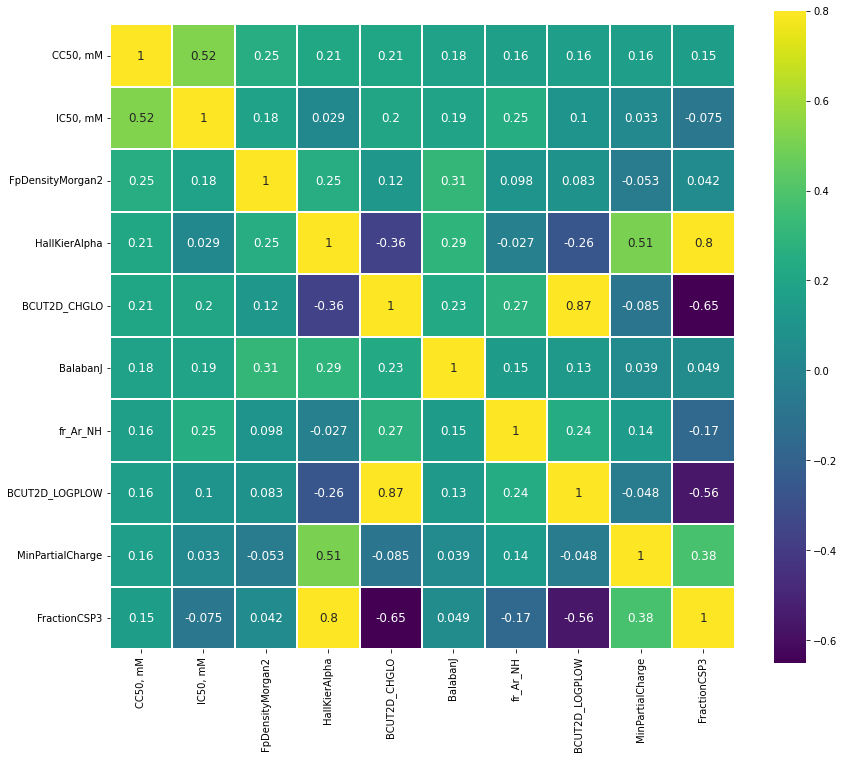

In [26]:
k = 10
cols = correlation_clear.nlargest(k,  'CC50, mM')[ 'CC50, mM'].index
cm = np.corrcoef(df[cols].values.T)
fig, axes = plt.subplots(figsize = (14, 12))

sns.heatmap(
    cm,
    vmax=.8,
    linewidths=0.01,
    cmap="viridis",
    square=True,
    annot=True,
    linecolor="white",
    xticklabels=cols.values,
    annot_kws = {"size": 12},
    yticklabels=cols.values
)

**Корреляция с целевой переменной SI(TOP 10)**

<AxesSubplot:>

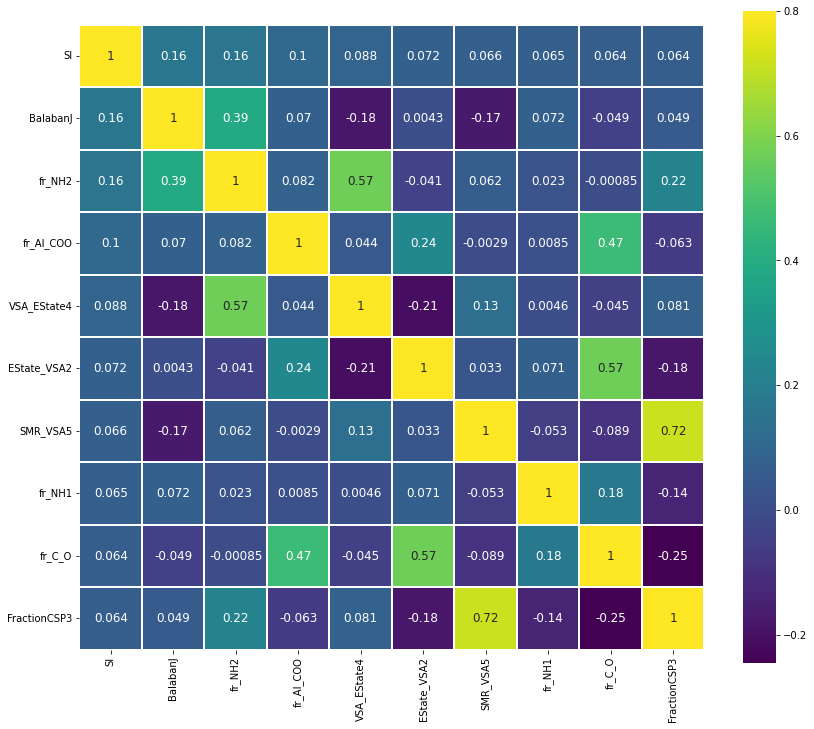

In [27]:
k = 10
cols = correlation_clear.nlargest(k,  'SI')[ 'SI'].index
cm = np.corrcoef(df[cols].values.T)
fig, axes = plt.subplots(figsize = (14, 12))

sns.heatmap(
    cm,
    vmax=.8,
    linewidths=0.01,
    cmap="viridis",
    square=True,
    annot=True,
    linecolor="white",
    xticklabels=cols.values,
    annot_kws = {"size": 12},
    yticklabels=cols.values
)

Из приведенных выше матриц корреляций мы видим что целевые переменные имеют очень слабую и слабую линейную корреляцию с другими признаками. Соответственно применение линейных моделей нецелесообразно.

**Нелинейная связь между признаками и целевой переменной IC50, mM**

In [28]:
target = df['IC50, mM']

In [29]:
%%time
parameters = {"max_depth": 6, "n_estimators": 25, "random_state": 27, "n_jobs": 2}

forest = RandomForestRegressor(**parameters)
forest.fit(df.drop(['CC50, mM','IC50, mM','SI'], axis=1), target)

CPU times: user 538 ms, sys: 3.86 ms, total: 542 ms
Wall time: 538 ms


RandomForestRegressor(max_depth=6, n_estimators=25, n_jobs=2, random_state=27)

Text(0.5, 1.0, 'What are the top important features to start with?')

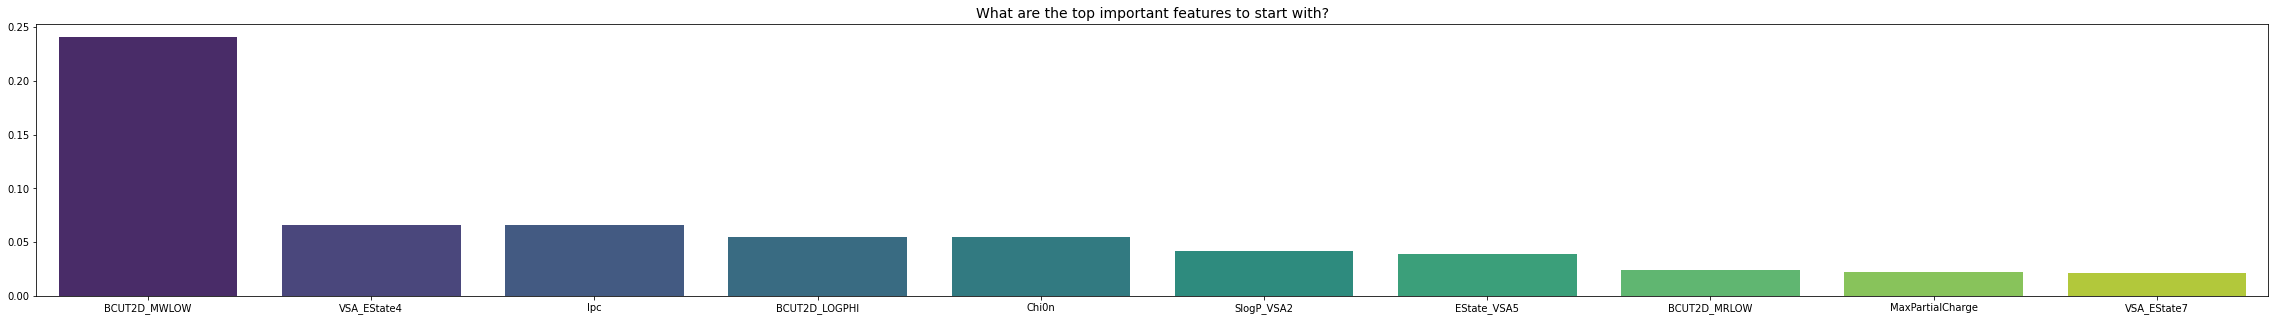

In [30]:
n_top = 10
importances = forest.feature_importances_
idx = np.argsort(importances)[::-1][0:n_top]
feature_names = df.drop(['CC50, mM','IC50, mM','SI'], axis=1).columns

plt.figure(figsize=(40, 5))
sns.barplot(x=feature_names[idx], y=importances[idx], palette="viridis")
plt.title("What are the top important features to start with?", size=14)

**Нелинейная связь между признаками и целевой переменной CC50, mM**

In [31]:
target = df['CC50, mM']

In [32]:
%%time
parameters = {"max_depth": 6, "n_estimators": 25, "random_state": 27, "n_jobs": 2}

forest = RandomForestRegressor(**parameters)
forest.fit(df.drop(['CC50, mM','IC50, mM','SI'], axis=1), target)

CPU times: user 495 ms, sys: 7.63 ms, total: 502 ms
Wall time: 270 ms


RandomForestRegressor(max_depth=6, n_estimators=25, n_jobs=2, random_state=27)

Text(0.5, 1.0, 'What are the top important features to start with?')

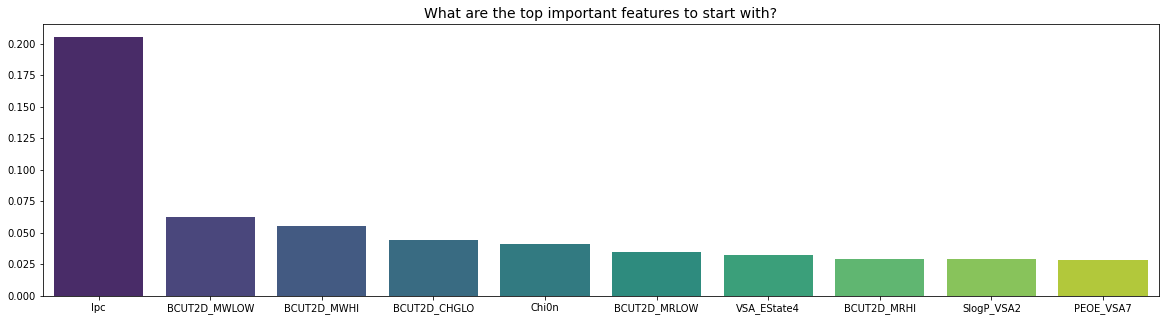

In [33]:
n_top = 10
importances = forest.feature_importances_
idx = np.argsort(importances)[::-1][0:n_top]
feature_names = df.drop(['CC50, mM','IC50, mM','SI'], axis=1).columns

plt.figure(figsize=(20, 5))
sns.barplot(x=feature_names[idx], y=importances[idx], palette="viridis")
plt.title("What are the top important features to start with?", size=14)

**Нелинейная связь между признаками и целевой переменной SI**

In [34]:
target = df['SI']

In [35]:
%%time
parameters = {"max_depth": 6, "n_estimators": 25, "random_state": 27, "n_jobs": 2}

forest = RandomForestRegressor(**parameters)
forest.fit(df.drop(['CC50, mM','IC50, mM','SI'], axis=1), target)

CPU times: user 442 ms, sys: 8.11 ms, total: 450 ms
Wall time: 235 ms


RandomForestRegressor(max_depth=6, n_estimators=25, n_jobs=2, random_state=27)

Text(0.5, 1.0, 'What are the top important features to start with?')

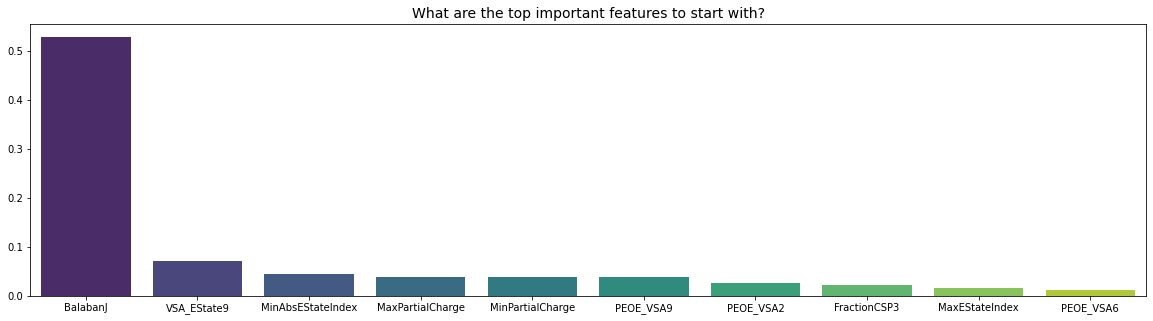

In [36]:
n_top = 10
importances = forest.feature_importances_
idx = np.argsort(importances)[::-1][0:n_top]
feature_names = df.drop(['CC50, mM','IC50, mM','SI'], axis=1).columns

plt.figure(figsize=(20, 5))
sns.barplot(x=feature_names[idx], y=importances[idx], palette="viridis")
plt.title("What are the top important features to start with?", size=14)

# Анализ выбросов целевых переменных

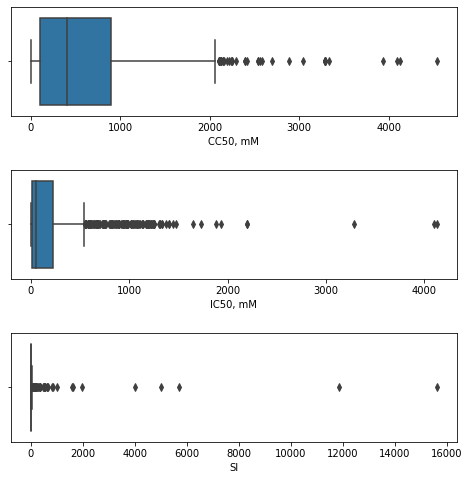

In [38]:
fig, axes = plt.subplots(3, 1, figsize=(8, 8))
plt.subplots_adjust(hspace=0.5)
for num, feature in enumerate(['CC50, mM','IC50, mM','SI']):
    sns.boxplot(data = df, x=feature, whis=1.5, orient='h', ax=axes[num])


Во всех целевых переменных мы можем наблюдать выбросы, но основное негативное влияние на метрики оно оказывает на целевую переменную 'SI', поэтому мы  удалим строки в которых значение целевой переменной больше 250.

In [39]:
data_SI = df[df['SI'] < 250]

<AxesSubplot:xlabel='SI'>

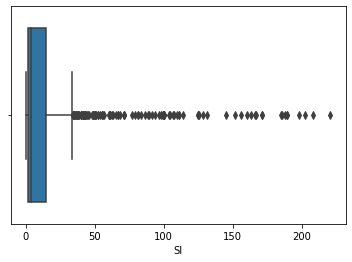

In [40]:
sns.boxplot(data = data_SI, x='SI', whis=1.5, orient='h')

## Обзор распределения целевых переменных задачи классификации: превышает ли значение IC50 медианное значение выборки.

In [41]:
val_median_CC50 = df['IC50, mM'].median()
df['IC50, mM'] = df['IC50, mM'].apply(lambda x: 0 if x < val_median_CC50 else 1)

In [42]:
df['IC50, mM'].value_counts()

0    499
1    499
Name: IC50, mM, dtype: int64

In [43]:
df['IC50, mM'].value_counts(normalize=True)

0    0.5
1    0.5
Name: IC50, mM, dtype: float64

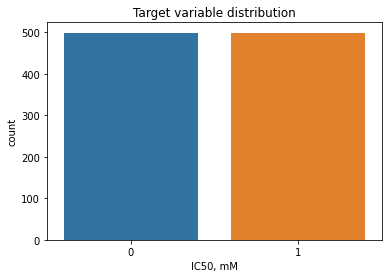

In [44]:
sns.countplot(x='IC50, mM', data=df)
plt.title('Target variable distribution');

Мы видим что классы распределены равномерно.

## Обзор распределения целевых переменных задачи классификации: превышает ли значение CC50 медианное значение выборки

In [46]:
val_median_CC50 = df['CC50, mM'].median()
df['CC50_med'] = df['CC50, mM'].apply(lambda x: 0 if x < val_median_CC50 else 1)

In [47]:
df['CC50_med'].value_counts()

0    499
1    499
Name: CC50_med, dtype: int64

In [48]:
df['CC50_med'].value_counts(normalize=True)

0    0.5
1    0.5
Name: CC50_med, dtype: float64

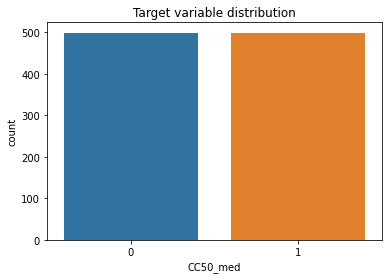

In [49]:
sns.countplot(x='CC50_med', data=df)
plt.title('Target variable distribution');

Мы видим что классы распределены равномерно.

## Обзор распределения целевых переменных задачи классификации: превышает ли значение SI медианное значение выборки.

In [50]:
val_median = data_SI['SI'].median()
data_SI['SI_med'] = data_SI['SI'].apply(lambda x: 0 if x < val_median else 1)

/tmp/ipykernel_133684/253886335.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_SI['SI_med'] = data_SI['SI'].apply(lambda x: 0 if x < val_median else 1)


In [51]:
data_SI['SI_med'].value_counts()

1    486
0    485
Name: SI_med, dtype: int64

In [52]:
data_SI['SI_med'].value_counts(normalize=True)

1    0.500515
0    0.499485
Name: SI_med, dtype: float64

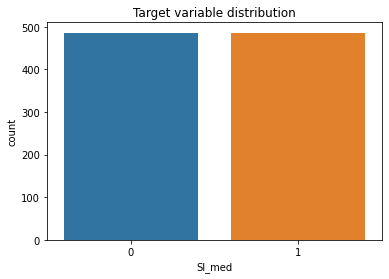

In [53]:
sns.countplot(x='SI_med', data=data_SI)
plt.title('Target variable distribution');

Мы видим что классы распределены равномерно.

## Обзор распределения целевых переменных задачи классификации: превышает ли значение SI значение 8

In [54]:
data_SI['SI_8'] = data_SI['SI'].apply(lambda x: 0 if x < 8 else 1)

/tmp/ipykernel_133684/2817534938.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_SI['SI_8'] = data_SI['SI'].apply(lambda x: 0 if x < 8 else 1)


In [59]:
data_SI['SI_8'] .value_counts()

0    641
1    330
Name: SI_8, dtype: int64

In [60]:
data_SI['SI_8'] .value_counts(normalize=True)

0    0.660144
1    0.339856
Name: SI_8, dtype: float64

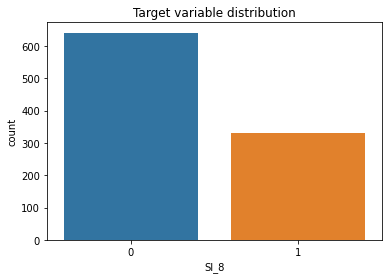

In [61]:
sns.countplot(x='SI_8', data=data_SI)
plt.title('Target variable distribution');

Мы видим преобладание класса 0 в датасете, но дисбаланс не критичный.